In [ ]:
!rm -rf /content/*

!git clone https://github.com/Dart-ilder/GoSlayer.git
%cd GoSlayer/

!pip install pyunpack patool

!mkdir data/maps1
!mkdir data/maps2
!mkdir data/maps3
!mkdir data/maps4
!mkdir data/maps5

from pyunpack import Archive
Archive('data/maps1.rar').extractall('data/maps1/')
Archive('data/maps2.rar').extractall('data/maps2/')
Archive('data/maps3.rar').extractall('data/maps3/')
Archive('data/maps4.rar').extractall('data/maps4/')

!pip install open3d

from transformers import pipeline
from PIL import Image
import requests
import numpy as np
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from PIL import Image
import requests
import numpy as np
import argparse
import cv2
import glob
import numpy as np
import open3d as o3d
import os
from PIL import Image
import torch
import os
import numpy as np
import open3d as o3d
import open3d as o3d
import numpy as np
import plotly.graph_objs as go
from plotly.offline import plot
from google.colab import files
from IPython.display import display
import re

In [ ]:
%cd /content
!git clone https://github.com/DepthAnything/Depth-Anything-V2
%cd Depth-Anything-V2/metric_depth
!pip install -r requirements.txt

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

os.makedirs('checkpoints', exist_ok=True)

checkpoint_urls = [
    'https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Large/resolve/main/depth_anything_v2_metric_vkitti_vitl.pth',
]

for url in checkpoint_urls:
    filename = url.split('/')[-1]
    os.system(f'wget -P checkpoints {url}')

print("Download completed!")

model_chekpoint = torch.load("/content/Depth-Anything-V2/metric_depth/checkpoints/depth_anything_v2_metric_vkitti_vitl.pth", map_location='cpu')

import cv2
import torch
from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl'
dataset = 'vkitti'
max_depth = 80

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(model_chekpoint)
model = model.to(DEVICE).eval()

%cd ../../GoSlayer/

In [5]:
Archive('data/maps_1key_noaug/processed/processed.rar').extractall('data/maps_1key_noaug/processed/')

In [ ]:
npz_files = glob.glob(os.path.join(f'data/maps_1key_noaug/processed', '*.npz'))

output_directory = f"data/point_clouds11/"
os.makedirs(output_directory, exist_ok=True)

def create_transformation_matrix(rotation, translation):
    transformation = np.eye(4)
    transformation[:3, :3] = rotation
    transformation[:3, 3] = translation
    return transformation

def transform_point_cloud(pcd, transformation):
    pcd.transform(transformation)
    return pcd

count = 0
for npz_file in npz_files:
    count += 1
    print(count)
    print(f'Loading {npz_file}...')
    file_number = re.findall(r'\d+', npz_file)[-1]
    data = np.load(npz_file)
    for i in range(data['images'].shape[1]):
          image0 = data['images'][0, i, 0, 0]
          image0 = Image.fromarray(image0)
          image1 = data['images'][0, i, 0, 1]
          image1 = Image.fromarray(image1)
          image2 = data['images'][0, i, 0, 2]
          image2 = Image.fromarray(image2)

          depth0 = model.infer_image(np.array(image0))
          depth1 = model.infer_image(np.array(image1))
          depth2 = model.infer_image(np.array(image2))

          height, width = depth0.shape
          focal_length_y = 117
          focal_length_x = 165

          x, y = np.meshgrid(np.arange(width), np.arange(height))
          x = (x - width / 2) / focal_length_x
          y = (y - height / 2) / focal_length_y
          z = np.array(depth0)
          points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
          points = points[(points[:, 1] < 3) * (points[:, 1] > -3)]
          points = points[np.random.choice(points.shape[0], 2000, replace=False)]


          pcd = o3d.geometry.PointCloud()
          pcd.points = o3d.utility.Vector3dVector(points)
          o3d.io.write_point_cloud("pointcloud0.ply", pcd)

          x, y = np.meshgrid(np.arange(width), np.arange(height))
          x = (x - width / 2) / focal_length_x
          y = (y - height / 2) / focal_length_y
          z = np.array(depth1)
          points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
          points = points[(points[:, 1] < 3) * (points[:, 1] > -3)]
          points = points[np.random.choice(points.shape[0], 2000, replace=False)]

          pcd = o3d.geometry.PointCloud()
          pcd.points = o3d.utility.Vector3dVector(points)
          o3d.io.write_point_cloud("pointcloud1.ply", pcd)

          x, y = np.meshgrid(np.arange(width), np.arange(height))
          x = (x - width / 2) / focal_length_x
          y = (y - height / 2) / focal_length_y
          z = np.array(depth2)
          points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
          points = points[(points[:, 1] < 3) * (points[:, 1] > -3)]
          points = points[np.random.choice(points.shape[0], 2000, replace=False)]

          pcd = o3d.geometry.PointCloud()
          pcd.points = o3d.utility.Vector3dVector(points)
          o3d.io.write_point_cloud("pointcloud2.ply", pcd)

          pcd0 = o3d.io.read_point_cloud("pointcloud0.ply")
          pcd1 = o3d.io.read_point_cloud("pointcloud1.ply")
          pcd2 = o3d.io.read_point_cloud("pointcloud2.ply")

          rotation_1 = o3d.geometry.get_rotation_matrix_from_xyz([0, -np.pi / 4, 0])
          translation_1 = np.array([0, 0, 0])

          rotation_2 = o3d.geometry.get_rotation_matrix_from_xyz([0, np.pi / 4, 0])
          translation_2 = np.array([0, 0, 0])

          transformation_1 = create_transformation_matrix(rotation_1, translation_1)
          transformation_2 = create_transformation_matrix(rotation_2, translation_2)

          pcd1_transformed = transform_point_cloud(pcd1, transformation_1)
          pcd2_transformed = transform_point_cloud(pcd2, transformation_2)

          merged_pcd = pcd0 + pcd1_transformed + pcd2_transformed

          merged_pcd = merged_pcd.voxel_down_sample(voxel_size=0.05)
          o3d.io.write_point_cloud(f"data/point_clouds11/map{file_number}_{i}.ply", merged_pcd)

In [45]:
!zip -r  maps.zip /content/GoSlayer/data/point_clouds11/

  adding: content/GoSlayer/data/point_clouds11/ (stored 0%)
  adding: content/GoSlayer/data/point_clouds11/map32_8.ply (deflated 19%)
  adding: content/GoSlayer/data/point_clouds11/map40_2.ply (deflated 19%)
  adding: content/GoSlayer/data/point_clouds11/map81_6.ply (deflated 18%)
  adding: content/GoSlayer/data/point_clouds11/map55_5.ply (deflated 18%)
  adding: content/GoSlayer/data/point_clouds11/map62_9.ply (deflated 18%)
  adding: content/GoSlayer/data/point_clouds11/map76_2.ply (deflated 18%)
  adding: content/GoSlayer/data/point_clouds11/map29_8.ply (deflated 17%)
  adding: content/GoSlayer/data/point_clouds11/map97_6.ply (deflated 17%)
  adding: content/GoSlayer/data/point_clouds11/map50_8.ply (deflated 17%)
  adding: content/GoSlayer/data/point_clouds11/map82_0.ply (deflated 18%)
  adding: content/GoSlayer/data/point_clouds11/map63_6.ply (deflated 18%)
  adding: content/GoSlayer/data/point_clouds11/map99_7.ply (deflated 19%)
  adding: content/GoSlayer/data/point_clouds11/map27

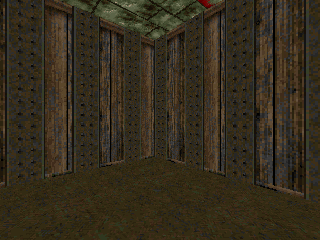

In [40]:
image0

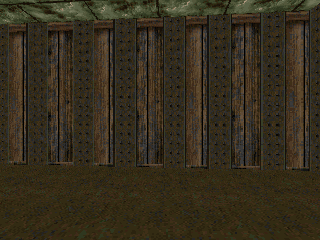

In [41]:
image1

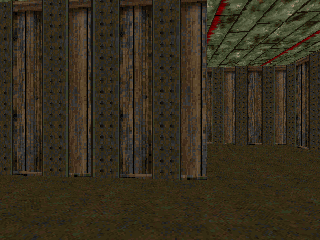

In [42]:
image2

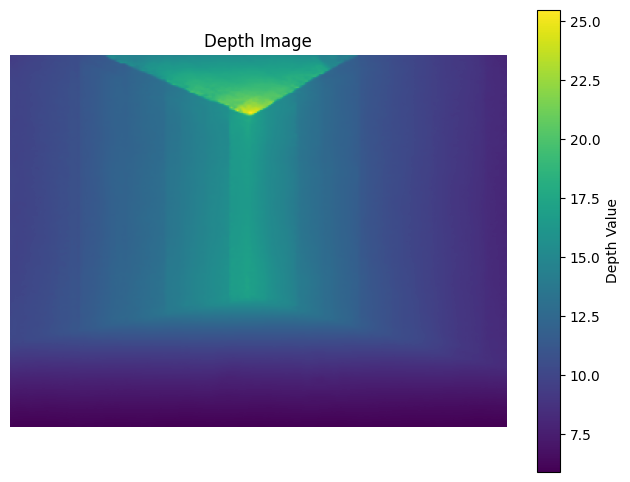

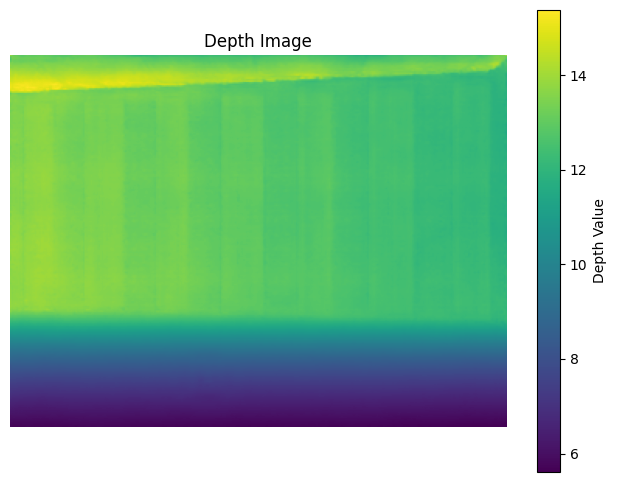

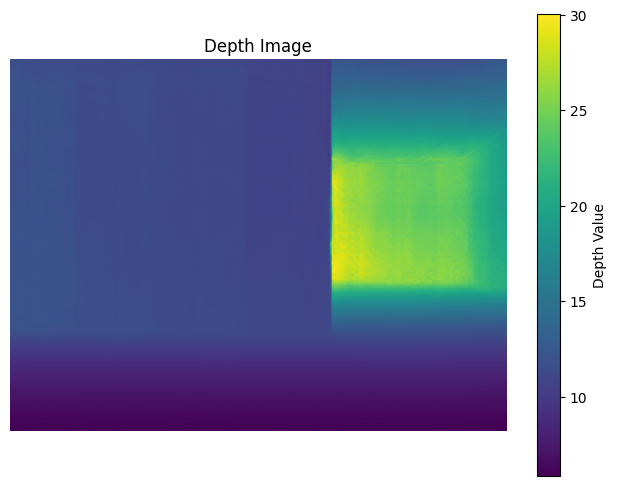

In [43]:
depth0 = model.infer_image(np.array(image0))
plt.figure(figsize=(8, 6))
plt.imshow(depth0, cmap='viridis')
plt.colorbar(label='Depth Value')
plt.title('Depth Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.axis('off')
plt.show()

depth1 = model.infer_image(np.array(image1))
plt.figure(figsize=(8, 6))
plt.imshow(depth1, cmap='viridis')
plt.colorbar(label='Depth Value')
plt.title('Depth Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.axis('off')
plt.show()

depth2 = model.infer_image(np.array(image2))
plt.figure(figsize=(8, 6))
plt.imshow(depth2, cmap='viridis')
plt.colorbar(label='Depth Value')
plt.title('Depth Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.axis('off')
plt.show()

In [44]:
import numpy as np
import open3d as o3d
import open3d as o3d
import numpy as np
import plotly.graph_objs as go
from plotly.offline import plot
from google.colab import files
from IPython.display import display

# Function to create a transformation matrix from rotation and translation
def create_transformation_matrix(rotation, translation):
    transformation = np.eye(4)
    transformation[:3, :3] = rotation  # Assign rotation
    transformation[:3, 3] = translation  # Assign translation
    return transformation

# Function to transform a point cloud using a transformation matrix
def transform_point_cloud(pcd, transformation):
    pcd.transform(transformation)  # Apply the 4x4 transformation
    return pcd

# Load or create your point clouds
pcd0 = o3d.io.read_point_cloud("pointcloud0.ply")
pcd1 = o3d.io.read_point_cloud("pointcloud1.ply")
pcd2 = o3d.io.read_point_cloud("pointcloud2.ply")

# Define rotations (45 degrees in radians)
rotation_1 = o3d.geometry.get_rotation_matrix_from_xyz([0, -np.pi / 4, 0])  # 45 degrees left
translation_1 = np.array([0, 0, 0])  # Example translation

rotation_2 = o3d.geometry.get_rotation_matrix_from_xyz([0, np.pi / 4, 0])  # 45 degrees right
translation_2 = np.array([0, 0, 0])  # Example translation

# Create transformation matrices
transformation_1 = create_transformation_matrix(rotation_1, translation_1)
transformation_2 = create_transformation_matrix(rotation_2, translation_2)

# Transform the point clouds
pcd1_transformed = transform_point_cloud(pcd1, transformation_1)
pcd2_transformed = transform_point_cloud(pcd2, transformation_2)

# Merge point clouds
merged_pcd = pcd0 + pcd1_transformed + pcd2_transformed

# Optionally remove duplicates
merged_pcd = merged_pcd.voxel_down_sample(voxel_size=0.05)  # Downsample as needed

# Save the merged point cloud
o3d.io.write_point_cloud("pointcloud3.ply", merged_pcd)

# Load the point cloud from the uploaded .ply file
pcd = o3d.io.read_point_cloud("pointcloud3.ply")
points = np.asarray(pcd.points)

# Optionally, downsample the points for faster rendering
sample_rate = 40000  # Adjust as needed
if len(points) > sample_rate:
    indices = np.random.choice(len(points), sample_rate, replace=False)
    sampled_points = points[indices]
else:
    sampled_points = points

# Create Plotly scatter plot
scatter = go.Scatter3d(
    x=sampled_points[:, 0],
    y=sampled_points[:, 1],
    z=sampled_points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=sampled_points[:, 2],
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title='3D Point Cloud Visualization',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[scatter], layout=layout)
fig.show()